Chaining: SIE to Power-law
==========================

In this script, we chain two searches to fit `Imaging` with a strong lens model where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllPowerLaw`.
 - The source galaxy's light is a parametric `EllSersic`.

The two searches break down as follows:

 1) Models the lens galaxy's mass as an `EllIsothermal` and the source galaxy's light as an `EllSersic`.
 2) Models the lens galaxy's mass an an `EllPowerLaw` and the source galaxy's light as an `EllSersic`.

__Why Chain?__

The `EllPower` is a general form of the `EllIsothermal` which has one additional parameter, the `slope`,
which controls the inner mass distribution as follows:

 - A higher slope concentrates more mass in the central regions of the mass profile relative to the outskirts.
 - A lower slope shallows the inner mass distribution reducing its density relative to the outskirts. 

By allowing the lens model to vary the mass profile's inner distribution, its non-linear parameter space becomes
significantly more complex and a notable degeneracy appears between the mass model`s mass normalization, elliptical
components and slope. This is challenging to sample in an efficient and robust manner, especially when the non-linear
search's initial samples use broad uniform priors on the lens and source parameters.

Search chaining allows us to begin by fitting an `EllIsothermal` model and therefore estimate the lens's mass
model and the source parameters via a non-linear parameter space that does not have a strong of a parameter degeneracy
present. This makes the model-fit more efficient and reliable.

The second search then fits the `EllPowerLaw`, using prior passing to initialize the mass and elliptical
components of the lens galaxy as well as the source galaxy's light profile.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

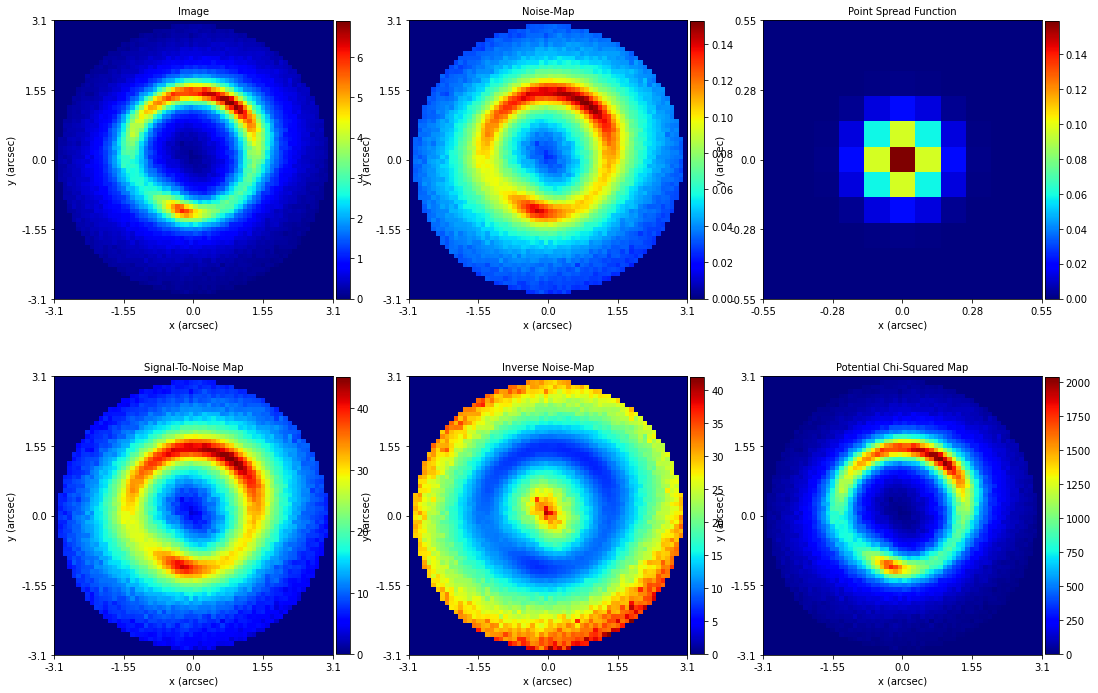

In [2]:
dataset_name = "mass_power_law__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "chaining", "sie_to_power_law")

__Model (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

In [4]:
lens = af.Model(
    al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal, shear=al.mp.ExternalShear
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search + Analysis + Model-Fit (Search 1)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.

In [5]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]__sie", unique_tag=dataset_name, nlive=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 14:54:38,325 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  6.77it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 14:54:38,641 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:54:38,773 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:54:38,894 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is an `EllPowerLaw` with `ExternalShear` [8 parameters: priors 
 initialized from search 1].
 - The source galaxy's light is again a parametric `EllSersic` [7 parameters: priors initialized from search 1].
 
The number of free parameters and therefore the dimensionality of non-linear parameter space is N=15.

The term `model` below passes the source model as model-components that are to be fitted for by the  non-linear search. 
Because the source model does not change we can pass its priors by simply using the`model` attribute of the result:

In [6]:
source = result_1.model.galaxies.source

However, we cannot use this to pass the lens galaxy, because its mass model must change from an `EllIsothermal` 
to an `EllPowerLaw`. The following code would not change the mass model to an `EllPowerLaw`:
 
 `lens = result.model.galaxies.lens`
 
We can instead use the `take_attributes` method to pass the priors. Below, we pass the lens of the result above to a
new `EllPowerLaw`, which will find all parameters in the `EllIsothermal` model that share the same name
as parameters in the `EllPowerLaw` and pass their priors (in this case, the `centre`, `elliptical_comps` 
and `einstein_radius`).

This leaves the `slope` parameter of the `EllPowerLaw` with its default `UniformPrior` which has a 
`lower_limit=1.5` and `upper_limit=3.0`.

In [7]:
mass = af.Model(al.mp.EllPowerLaw)
mass.take_attributes(result_1.model.galaxies.lens.mass)
shear = result_1.model.galaxies.lens.shear

lens = af.Model(al.Galaxy, redshift=0.5, mass=mass, shear=shear)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search + Analysis + Model-Fit (Search 2)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the `model.info` file of the search 2 model-fit to ensure the priors were passed correctly, as 
well as the checkout the results to ensure an accurate power-law mass model is inferred.

In [8]:
search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]__power_law",
    unique_tag=dataset_name,
    nlive=75,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 14:54:39,719 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 94.83it/s, +75 | bound: 0 | nc: 1 | ncall: 77 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.084]
2021-05-10 14:54:39,759 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:54:39,918 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:54:40,062 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Wrap Up__

In this example, we passed used prior passing to initialize a lens mass model as an `EllIsothermal` and 
passed its priors to then fit the more complex `EllPowerLaw` model. 

This removed difficult-to-fit degeneracies from the non-linear parameter space in search 1, providing a more robust 
and efficient model-fit.

__Pipelines__

Advanced search chaining uses `pipelines` that chain together multiple searches to perform complex lens modeling 
in a robust and efficient way. 

The following example pipelines fits a power-law, using the same approach demonstrated in this script of first 
fitting an `EllIsothermal`:

 `autolens_workspace/imaging/chaining/pipelines/no_lens_light/mass_total__source_parametric.py`
 
 __SLaM (Source, Light and Mass)__
 
An even more advanced approach which uses search chaining are the SLaM pipelines, which break the lens modeling 
processing into a series of fits that first perfect the source model, then the lens light model and finally the lens
mass model. 

The SLaM pipelines assume an `EllIsothermal` throughout the Source and Light pipelines, and only switch to a
more complex mass model (like the `EllPowerLaw`) in the final Mass pipeline.